In [1]:
import pandas as pd
import numpy as np

import shap
import os
import sys
import collections
import torch
import matplotlib.pyplot as plt

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from utilities import normalize_data, Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models as cate_models
import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:


import numpy as np
import matplotlib.pyplot as plt

def plot_categorical_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]
    
    agg_shap = []
    agg_x_test = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_instance = [np.argmax(l) if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test.append(agg_x_test_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test = np.array(agg_x_test)

    # Determine the indices of categorical features
    categorical_indices = [i for i, n in enumerate(n_categories) if n > 1]
    
    for cat_index in categorical_indices:
        # Plot SHAP values for each category
        unique_categories = np.unique(agg_x_test[:, cat_index])
        for cat in unique_categories:
            shap_values_cat = agg_shap[agg_x_test[:, cat_index] == cat, cat_index]
            plt.scatter([cat]*len(shap_values_cat), shap_values_cat,s=4, label=f'Category {cat}')

        plt.title(f"Feature: {feature_names[cat_index]}")
        plt.xlabel("Category")
        plt.ylabel("SHAP Value")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()



        
def plot_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]  # Determine split indices based on n_categories
    
    agg_shap = []
    agg_x_test_colors = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_colors_instance = [l[np.argmax(l)] if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test_colors.append(agg_x_test_colors_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test_colors = np.array(agg_x_test_colors)

    # Determine the indices of the features with highest mean absolute SHAP values
    ind = np.argpartition(np.abs(agg_shap).mean(0), -len(n_categories))[-len(n_categories):]
    
    # Create the feature names with associated mean absolute SHAP values
    ranked_feature_names = [f"{a}: {b:.3f}" for a, b in zip(feature_names[ind], np.abs(agg_shap[:, ind]).mean(0))]

    # Plot the summary
    shap.summary_plot(agg_shap[:, ind], agg_x_test_colors[:, ind], feature_names=ranked_feature_names)


def plot_feature_values_original(feature_values, x_test):

    feature_num = feature_values.shape[1]
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(3), -feature_num)[-feature_num:]
    
    
    ranked_feature_names = [
        a + ": " + str(b) for a,b in zip(feature_names_v2[ind], np.abs(feature_values[:, ind]).mean(0).round(3))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=ranked_feature_names,
        title = "IG"
     )


def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = x_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(4), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

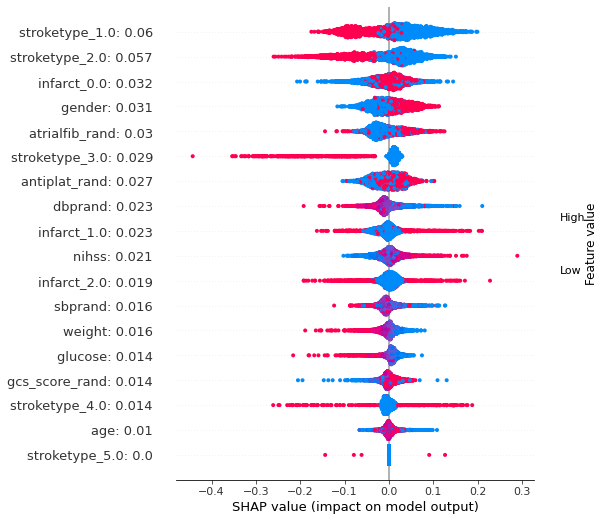

In [82]:
ist3 = pd.read_sas("data/datashare_aug2015.sas7bdat")

continuous_vars = [
    "gender",
    "age",
    "weight",
    "glucose",
    # "gcs_eye_rand",
    # "gcs_motor_rand",
    # "gcs_verbal_rand",
    "gcs_score_rand",   
     "nihss" ,
     "sbprand",
     "dbprand",
     "antiplat_rand",
     "atrialfib_rand"
]

cate_variables = [
     # "livealone_rand",
     # "indepinadl_rand",
     "infarct",
     # "atrialfib_rand",
    #  "liftarms_rand",
    # "ablewalk_rand",
    # "weakface_rand",
    # "weakarm_rand",
    # "weakleg_rand",
    # "dysphasia_rand",
    # "hemianopia_rand",
    # "visuospat_rand",
    # "brainstemsigns_rand",
    # "otherdeficit_rand",
    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

x = ist3[continuous_vars + cate_variables + treatment]

x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
x["gender"] = np.where(x["gender"]== 2, 1, 0)

feature_names = x.drop(treatment, axis=1).columns

n_categories = [x[i].nunique() if i in cate_variables else 1 for i in feature_names]

x = pd.get_dummies(x, columns=cate_variables)

feature_names_v2 = x.drop(treatment, axis=1).columns

n, feature_size = x.shape

treatment_index = x.columns.get_loc("itt_treat")
var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=42,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=42,
                                    )

w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:, var_index]
x_test = x_test[:, var_index]
x_val = x_val[:, var_index]

y_train = y_train == 1
y_test = y_test == 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9020289182662964, train_loss: 0.9569461941719055
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.6023674011230469, train_loss: 0.5802776217460632
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5099820494651794, train_loss: 0.44087281823158264
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.4794251620769501, train_loss: 0.3836422860622406
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4691794812679291, train_loss: 0.33770552277565
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6585721373558044, train_loss: 0.6667695641517639
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5456935167312622, train_loss: 0.49003005027770996
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5274766087532043, train_loss: 0.43277814984321594
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.5266118645

Permutation explainer: 3036it [01:48, 25.38it/s]                                


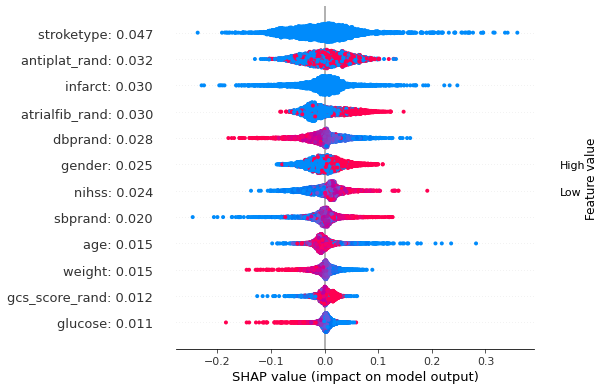

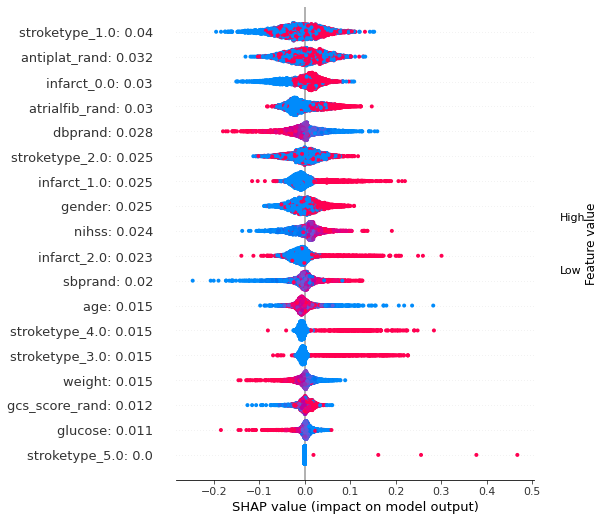

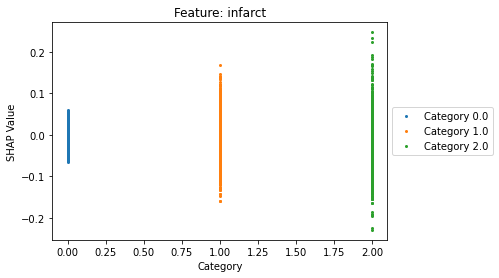

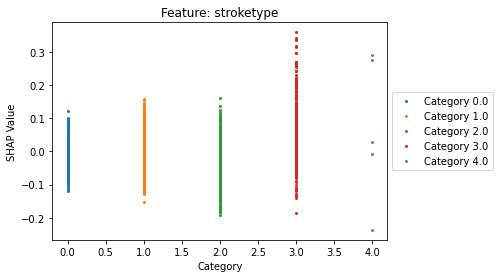

In [99]:
model = pseudo_outcome_nets.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


def model_predict(X):
    return model.predict(X).detach().cpu().numpy()


model.fit(x_train, y_train, w_train)

baseline = np.concatenate([x_train, x_val,x_test], axis=0)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_feature_values_original(shap_values.values, baseline)

plot_categorical_feature_values(shap_values.values, baseline, n_categories)


[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6138721704483032, train_loss: 0.6458441019058228
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.45374795794487, train_loss: 0.48837146162986755
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.43283316493034363, train_loss: 0.44245123863220215
[po_est_impute_unconditional_mean] Epoch: 150, current validation loss: 0.42693275213241577, train_loss: 0.41558700799942017
[po_est_impute_unconditional_mean] Epoch: 200, current validation loss: 0.4265056550502777, train_loss: 0.41207605600357056
[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6819400787353516, train_loss: 0.6906774640083313
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.5722461342811584, train_loss: 0.5007331371307373
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.5673696994781494, train_loss: 0.4491886496543884
[po_est_impute_unc

Permutation explainer: 3036it [00:49, 48.75it/s]                                


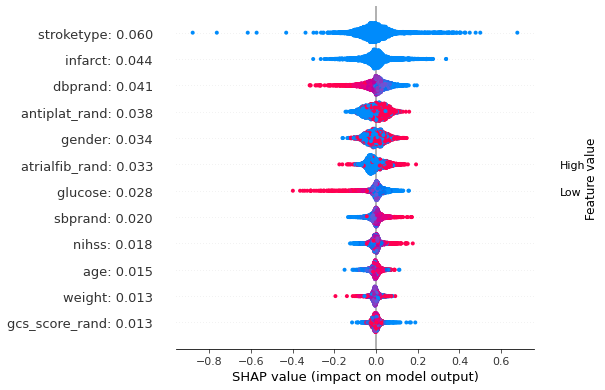

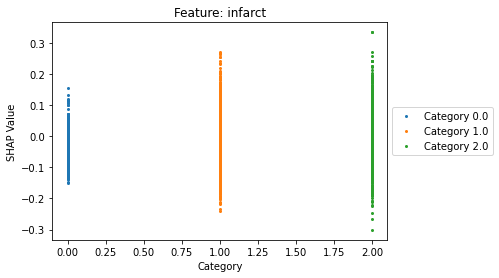

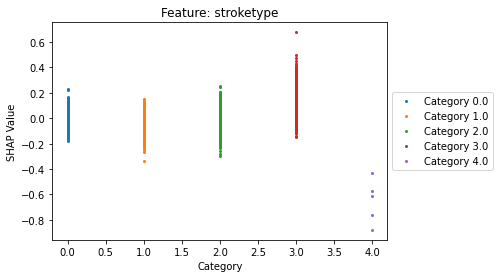

In [72]:
model = pseudo_outcome_nets.RLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

learner_explanations = {}

# learner_explanations["shapley_sampling"] = np.zeros((x_test.shape))
# marginal_extension = removal.MarginalExtension(x_test, model)

# for test_ind in range(len(x_test)):
#     instance = x_test[test_ind]
#     game = games.PredictionGame(marginal_extension, instance)
#     explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
#     learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, x_test.shape[1])

# plot_feature_values(learner_explanations["shapley_sampling"])

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9554045796394348, train_loss: 0.9926087260246277
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5899448990821838, train_loss: 0.5736987590789795
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5009039640426636, train_loss: 0.44446292519569397
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.480671226978302, train_loss: 0.38867247104644775
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.47752100229263306, train_loss: 0.3484068810939789
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6873695254325867, train_loss: 0.7140087485313416
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5291489362716675, train_loss: 0.5072386860847473
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5072816014289856, train_loss: 0.4401850402355194
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.503801047

Permutation explainer: 3036it [00:49, 48.50it/s]                                


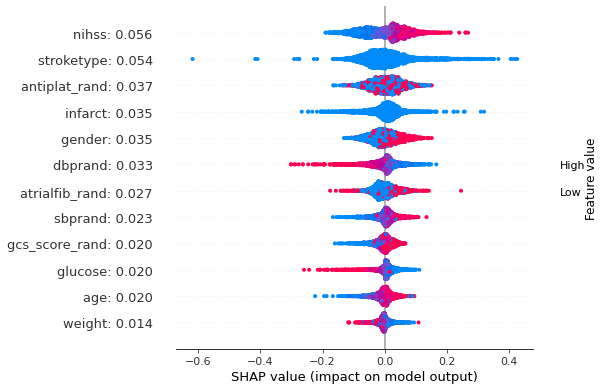

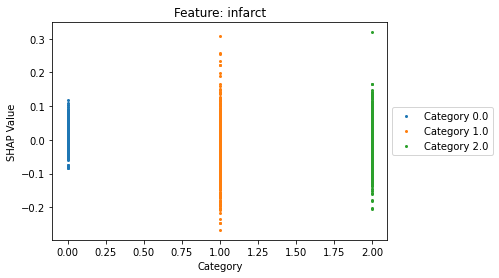

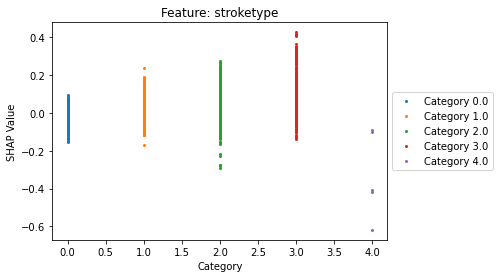

In [73]:
model = pseudo_outcome_nets.RALearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[TARNet] Epoch: 0, current validation loss: 0.6893719434738159 train_loss: 0.6900596022605896
[TARNet] Epoch: 50, current validation loss: 0.6488354206085205 train_loss: 0.64727783203125
[TARNet] Epoch: 100, current validation loss: 0.5971236228942871 train_loss: 0.588253915309906
[TARNet] Epoch: 150, current validation loss: 0.5569208264350891 train_loss: 0.5351617932319641
[TARNet] Epoch: 200, current validation loss: 0.5440869927406311 train_loss: 0.5155655145645142
[TARNet] Epoch: 250, current validation loss: 0.537254810333252 train_loss: 0.5045313835144043
[TARNet] Epoch: 300, current validation loss: 0.5317315459251404 train_loss: 0.4943632483482361
[TARNet] Epoch: 350, current validation loss: 0.5270311832427979 train_loss: 0.4881545603275299
[TARNet] Epoch: 400, current validation loss: 0.5236188173294067 train_loss: 0.4803340435028076
[TARNet] Epoch: 450, current validation loss: 0.521166205406189 train_loss: 0.47150352597236633
[TARNet] Epoch: 500, current validation loss: 0

Permutation explainer: 3036it [01:29, 29.92it/s]                                


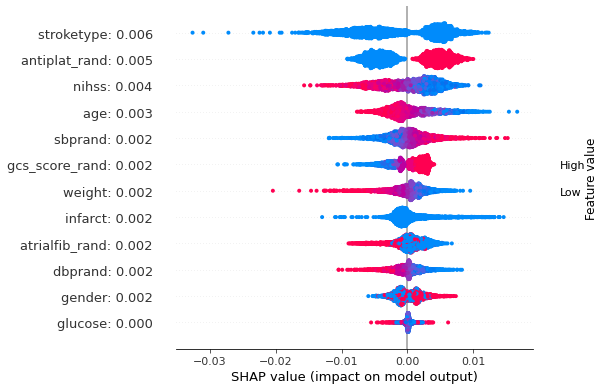

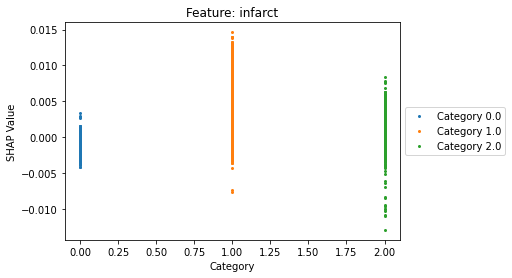

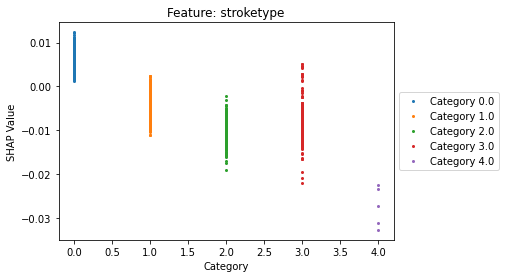

In [74]:
model = cate_models.torch.TARNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            n_layers_r=2,
            n_layers_out=2,
            n_units_out=100,
            n_units_r=100,
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            early_stopping = True,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[DragonNet] Epoch: 0, current validation loss: 1.3849462270736694 train_loss: 1.385475754737854
[DragonNet] Epoch: 50, current validation loss: 1.3019402027130127 train_loss: 1.2929776906967163
[DragonNet] Epoch: 100, current validation loss: 1.240375280380249 train_loss: 1.2152279615402222
[DragonNet] Epoch: 150, current validation loss: 1.2227540016174316 train_loss: 1.1884409189224243
[DragonNet] Epoch: 200, current validation loss: 1.2129709720611572 train_loss: 1.1677701473236084
[DragonNet] Epoch: 250, current validation loss: 1.2092010974884033 train_loss: 1.1542671918869019


Permutation explainer: 3036it [02:32, 18.57it/s]                                


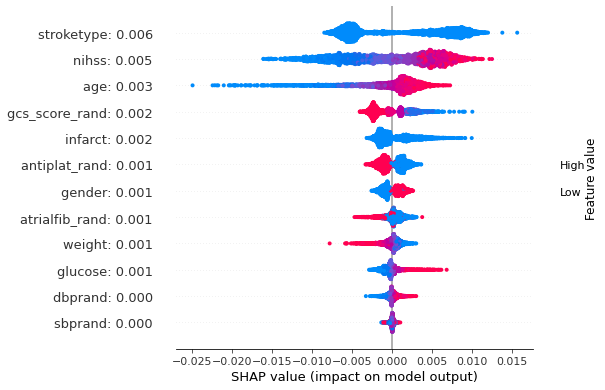

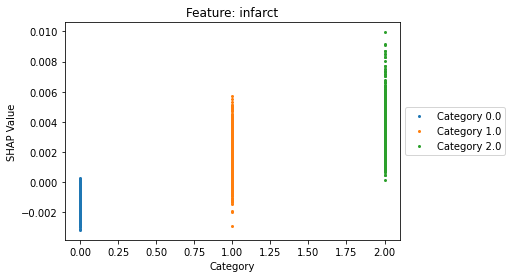

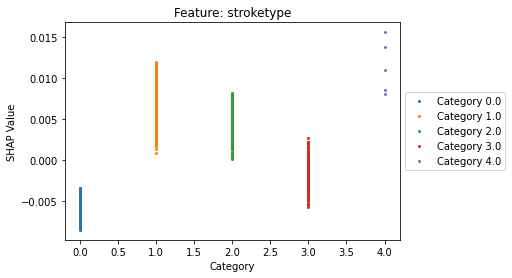

In [75]:
model = cate_models.torch.DragonNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[slearner_po_estimator] Epoch: 0, current validation loss: 0.7561942338943481, train_loss: 0.7621263265609741
[slearner_po_estimator] Epoch: 50, current validation loss: 0.4989801347255707, train_loss: 0.48219841718673706
[slearner_po_estimator] Epoch: 100, current validation loss: 0.4801802635192871, train_loss: 0.4397190809249878
[slearner_po_estimator] Epoch: 150, current validation loss: 0.4787187874317169, train_loss: 0.4239770770072937
[slearner_po_estimator] Epoch: 200, current validation loss: 0.4785993695259094, train_loss: 0.4225805401802063


Permutation explainer: 3036it [01:28, 30.19it/s]                                


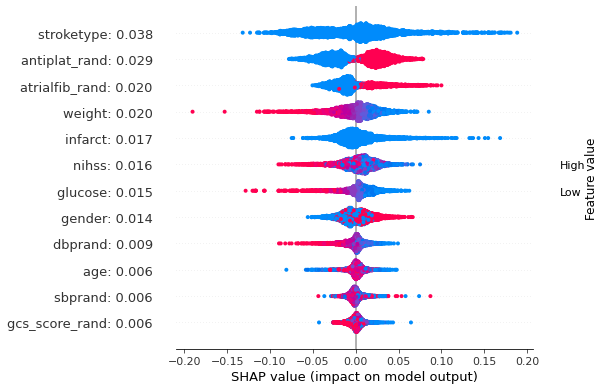

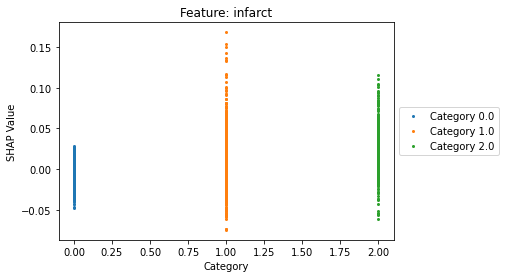

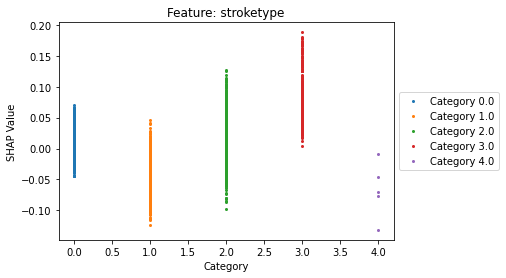

In [76]:
model = cate_models.torch.SLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

In [ ]:
model = cate_models.torch.TLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0), n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7552102208137512, train_loss: 0.7444889545440674
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5285875201225281, train_loss: 0.4970513582229614
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.4879630506038666, train_loss: 0.43373599648475647
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.4751794934272766, train_loss: 0.38654184341430664
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4693801999092102, train_loss: 0.3650873601436615
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6363965272903442, train_loss: 0.669018566608429
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5158784985542297, train_loss: 0.4900670349597931
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5132080912590027, train_loss: 0.4525911509990692
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.5134476423

Permutation explainer: 2550it [02:23, 16.44it/s]                                


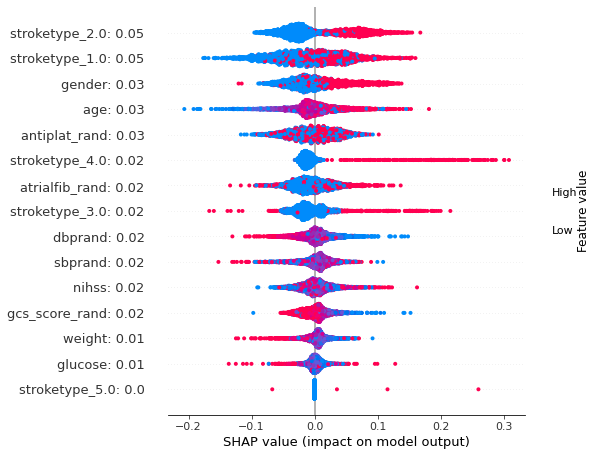

In [110]:
model = cate_models.torch.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0))

average tx effect 0.0062297457
average tx effect 0.00623464


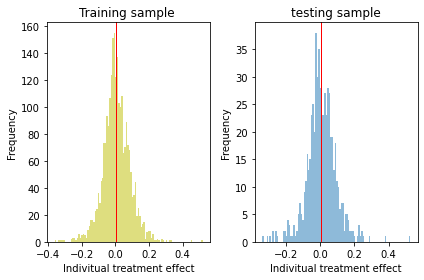

In [53]:
import matplotlib.pyplot as plt 

train_output = model(x_train).detach().cpu().numpy()
test_output = model(x_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(train_output), linewidth=1, color='r')

plt.title("Training sample " )
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output,bins=100 , alpha = 0.5)
plt.axvline(x= np.mean(test_output), linewidth=1, color='r')

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

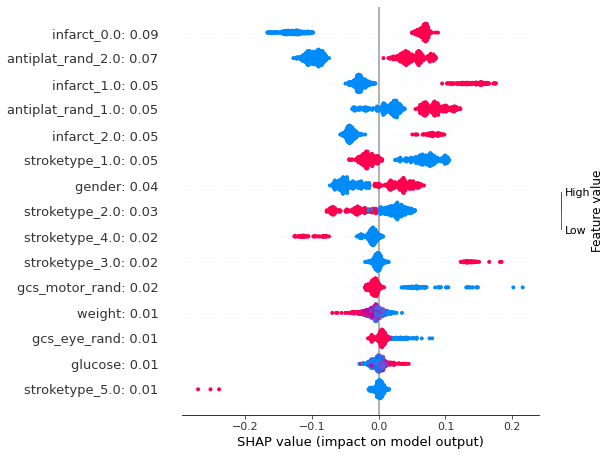

In [54]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [ ]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

In [ ]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

In [4]:
cohort_name = "ist3"

trials = 5
top_n_features = 10
learner = "xlearner"

data = Dataset(cohort_name)
x_train, w_train, y_train = data.get_training_data()
x_test, w_test, y_test = data.get_training_data()
replacement_value = data.get_features_mins()

names = data.get_feature_names()

feature_size = x_train.shape[1]

device = "cuda:3"

learner_explanations = {}

models = {
    "xlearner":
        pseudo_outcome_nets.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1500,
        nonlin="relu",
        device=device,
    ),
    "drlearner":
        pseudo_outcome_nets.DRLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1500,
        nonlin="relu",
        device=device,
    )
}
explainers = [
    "ig", 
    "shapley_sampling_0", 
    "shap"
]

top_k_results = {
    "ig":[],
    "shapley_sampling_0":[],
    "shap":[]
    }

result_sign = {
    "ig": np.zeros((trials,feature_size)),
    "shapley_sampling_0": np.zeros((trials,feature_size)),
    "shap": np.zeros((trials,feature_size))
    }

results_train = np.zeros((trials, len(x_train)))
results_test = np.zeros((trials, len(x_test)))

#### Getting top n features from multiple runs. 

for i in range(trials):

    insertion_deletion_data = []

    model = models[learner]
    model.fit(x_train, y_train, w_train)

    results_train[i] = model(x_train).detach().cpu().numpy().flatten()
    results_test[i] = model(x_test).detach().cpu().numpy().flatten()

    ig = IntegratedGradients(model)

    print("==================================================")
    print("explaining with IG")

    learner_explanations["ig"] = ig.attribute(
                                        torch.from_numpy(x_test).to(device).requires_grad_(),
                                        n_steps=500,
                                ).detach().cpu().numpy()

    print("==================================================")
    print("explaining with shapley sampling -0")

    rank_indices = attribution_ranking(learner_explanations["ig"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )
    insertion_deletion_data.append(
        [
            "ig",
            insertion_results, 
            deletion_results
        ]
    )

    shapley_value_sampling_model = ShapleyValueSampling(model)
    learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                    torch.from_numpy(x_test).to(device).requires_grad_(),
                                                    n_samples=500,
                                                    perturbations_per_eval=10,
                                                ).detach().cpu().numpy()

    print("==================================================")
    print("explaining with shapley sampling - marginal distribution")

    rank_indices = attribution_ranking(learner_explanations["shapley_sampling_0"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )
    insertion_deletion_data.append(
        [
            "shapley_sampling_0",
            insertion_results, 
            deletion_results
        ]
    )
    marginal_extension = removal.MarginalExtension(x_test, model)
    shap_values = np.zeros((x_test.shape))

    for test_ind in range(len(x_test)):
        instance = x_test[test_ind]
        game = games.PredictionGame(marginal_extension, instance)
        explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
        shap_values[test_ind] = explanation.values.reshape(-1, x_test.shape[1])

    learner_explanations["shap"] = shap_values

    rank_indices = attribution_ranking(learner_explanations["shap"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )

    insertion_deletion_data.append(
        [
            "shap",
            insertion_results, 
            deletion_results
        ]
    )

    with open( f"results/{cohort_name}/insertion_deletion_{learner}_{i}.pkl", "wb") as output_file:    
        pickle.dump(insertion_deletion_data, output_file)

    #### Getting top n features

    for e in explainers:
        ind = np.argpartition(np.abs(learner_explanations[e]).mean(0).round(2), -top_n_features)[-top_n_features:]
        top_k_results[e].extend(names[ind].tolist())

        for col in range(feature_size):
            result_sign[e][i, col] = stats.pearsonr(x_test[:,col], learner_explanations[e][:, col])[0]

for e in explainers:
    results = collections.Counter(top_k_results[e])
    summary = pd.DataFrame(results.items(), columns=['feature', 'count (%)']).sort_values(by="count (%)", ascending=False)
    summary["count (%)"] = np.round(summary["count (%)"]/trials,2)*100

    indices = [names.tolist().index(i) for i in summary.feature.tolist()]
    summary["sign"] = np.sign(np.mean(result_sign[e], axis=(0))[indices])

    summary.to_csv(f"results/{cohort_name}/{e}_top_{top_n_features}_features_{learner}.csv")

with open( f"results/{cohort_name}/train_{learner}.pkl", "wb") as output_file:    
    pickle.dump(results_train, output_file)

with open( f"results/{cohort_name}/test_{learner}.pkl", "wb") as output_file:    
    pickle.dump(results_test, output_file)


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.27700456976890564, train_loss: 0.31041598320007324
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.027806375175714493, train_loss: 0.016971692442893982
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.020027320832014084, train_loss: 0.006622212938964367
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.017219392582774162, train_loss: 0.006562903523445129
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.01706978678703308, train_loss: 0.006967932917177677
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.35028767585754395, train_loss: 0.4255410432815552
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.023664774373173714, train_loss: 0.015478557907044888
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.015027287416160107, train_loss: 0.0068418290466070175
[po_estimator_1_impute_pos] Epoch: 150, current val

 19%|███████▍                                | 0.1869/1 [00:08<00:36, 44.29s/it]

KeyboardInterrupt: 